In [ ]:
%load_ext tensorboard

In [1]:
import glob
import pandas as pd
import numpy as np

In [2]:
allFiles = glob.glob("dp/notebooks/lexicons/*")
allFiles.sort()
allDF = []

for f in allFiles:
    filename = f.split("/")[3][:-4]
    df = pd.read_csv(f, dtype=str, engine='python',
        encoding='utf-8', sep='\t',
        names=['grapheme', 'phoneme'])
    df.insert(2, 'filename', filename)
    allDF.append(df)

df = pd.concat(allDF, ignore_index=True)
df.insert(0, 'lang', 'pt_br')
df['phoneme'] = df['phoneme'].str.strip()

<AxesSubplot:>

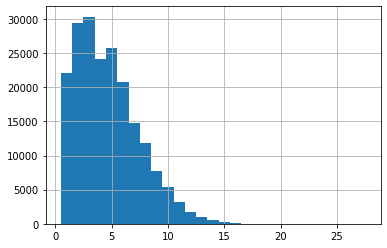

In [3]:
#tamanho de cada palavra
wordLen = df['grapheme'].apply(lambda x: [len(w) for w in x.split()])
data = pd.DataFrame( {'column':np.concatenate(wordLen.values)} )['column']
data.hist(bins=[i+0.5 for i in range(data.max()+1)])

<AxesSubplot:>

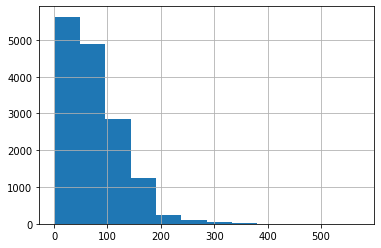

In [4]:
#número de grafemas de cada sentença
sentenceGraphemeLen = df['grapheme'].str.len()
sentenceGraphemeLen.hist(bins=12)

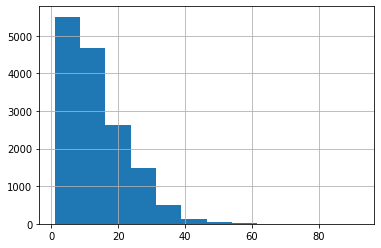

In [5]:
#número de palavras de cada sentença
sentenceWordLen = df['grapheme'].str.split().str.len().hist(bins=12)

In [6]:
df['grapheme'] = df['grapheme'].map(str)
df['phoneme'] = df['phoneme'].map(str)

df['phoneme'] = df['phoneme'].str.replace("\\\\pau\\\\", '\\\\,\\\\')
df['phoneme'] = df['phoneme'].str.replace("a~", "ã")
df['phoneme'] = df['phoneme'].str.replace("e~", "ẽ")
df['phoneme'] = df['phoneme'].str.replace("i~", "ĩ")
df['phoneme'] = df['phoneme'].str.replace("o~", "õ")
df['phoneme'] = df['phoneme'].str.replace("u~", "ũ")
df['phoneme'] = df['phoneme'].str.replace("w~", "w̃")
df['phoneme'] = df['phoneme'].str.replace("j~", "j̃")

In [7]:
graphemes = ''.join(sorted(list(set(df['grapheme'].sum()))))

phonemes = pd.DataFrame(
    df['phoneme'].str.split("\\")
        .explode().drop_duplicates()
        .sort_values().reset_index(drop=True)
        .values.tolist(), columns=['phon']
)

phonemes['len'] = phonemes['phon'].str.len()
phonemes['upper'] = phonemes['phon'].str.isupper()
phonemes = phonemes.sort_values(by=['len', 'upper', 'phon'], ascending=False)['phon'].values.tolist()

phonemes.append("~")
phonemes.remove(" '")
phonemes.remove("")

df['phoneme'] = df['phoneme'].str.replace('\\', '')

In [11]:
df['phoneme'][df['grapheme'].str.contains('não', na=False)]

139      poX'ki 'nãw̃ 'pu.dZi e.vi'taX, 'E.la mi Res.põ...
143      ob.via'mẽ.tSi, u bra'ziw dZi kĩ'Jẽ.tus, Zo'ãw̃...
147      ũ se'gũ.du ob.Ze'tSi.vu 'des.tSi 'li.vru, 'tãw...
162      a mu'dã.sa da 'kOX.tSi 'pa.ra u bra'ziw 'e.ra ...
163      si 'nãw̃ a'vi.a aw.teR.na'tSi.va, tã'bẽj̃ 'nãw...
                               ...                        
15011    'sobri ajs e.mo'sõj̃s 'tẽ.Ju ku.rio.zi'da.dZi,...
15015    i a'gO.ra 'pE.dẽj̃.mi ki 'fa.li 'sobri 'mĩ 'me...
15017    'tu.du u ki po'dẽ.mus dZi'zeX 'sobri 'nO.sajs ...
15021    tu 'nãw̃ tẽs po'deX 'sobri u 'tẽ.pu ki 'vi.vi,...
15030    vo'se a.kre'dZi.ta ẽj̃'vi.da 'pOjs 'mOX.tSi, ẽ...
Name: phoneme, Length: 2342, dtype: object

In [13]:
hist = df.copy()
hist.phoneme = hist.phoneme.str.len()
hist.grapheme = hist.grapheme.str.len()

<AxesSubplot:>

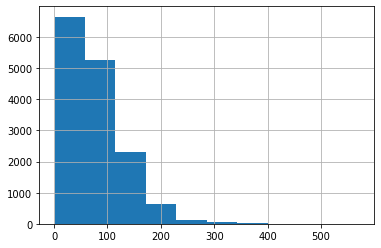

In [14]:
hist['grapheme'].hist()

<AxesSubplot:>

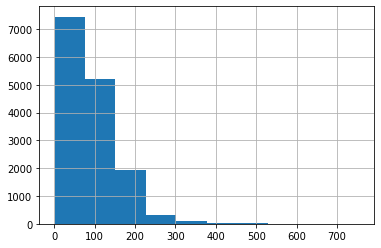

In [15]:
hist['phoneme'].hist()

In [16]:
print(hist['grapheme'].max(), hist['phoneme'].max())

571 754


In [17]:
hist['phoneme'].idxmax()

517

In [25]:
print(df.iloc[517]['grapheme'])

Pelo tratado de Fontainebleau, assinado pelos dois aliados em 27 de outubro de 1807, Portugal seria retalhado em três partes: a região norte, composta pelas províncias de Entre-Douro e Minho e batizada, pelo tratado, de Lusitânia Setentrional, caberia à rainha regente da Etrúria, Maria Luiza de Bourbon, da dinastia espanhola; Alentejo e Algarve, na região sul, passariam para D. Manoel de Godoy, o mais poderoso ministro espanhol, também chamado de príncipe da Paz; à França caberia a parte central e mais rica do país, composta por Beira, Trás os Montes e Estremadura.


In [7]:
df['gsize'] = df['grapheme'].apply(lambda x : len(x))
df['psize'] = df['phoneme'].apply(lambda x : len(x))
df = df[df['psize'] <= 100]
phonemes.sort(key=len, reverse=True)

In [87]:
df['gWords'] = df['grapheme'].str.count(' ') + 1
df['pWords'] = df['phoneme'].str.count(' ') + 1
df['grapheme'] = df['grapheme'].str.split(' ')
df['phoneme'] = df['phoneme'].str.split(' ')

In [88]:
df = (df.groupby('filename', as_index=False)
    .apply(lambda x: x.reset_index(drop=True)).reset_index().drop('level_0', axis=1))
df.level_1 = df.level_1 + 1

In [89]:
df[df.gWords > df.pWords].apply(lambda x:
    x.phoneme.extend([''] * (x.gWords - x.pWords)), axis=1)
df[df.pWords > df.gWords].apply(lambda x:
    x.grapheme.extend([''] * (x.pWords - x.gWords)), axis=1)
dfWords = (df.apply(pd.Series.explode)
    .drop(['lang', 'gWords', 'pWords'], axis=1))

In [6]:
allFilesFixed = glob.glob("dp/notebooks/lexicons_fixed/*")
allFilesFixed.sort()
allDFFixed = []

for f in allFilesFixed:
    filename = f.split("/")[3][:-4]
    dfFixed = pd.read_csv(f, dtype=str,
        encoding='utf-8', sep='\\t',
        names=['grapheme', 'phoneme'])
    dfFixed.insert(2, 'filename', filename)
    allDFFixed.append(dfFixed)

dfFixed = pd.concat(allDFFixed, ignore_index=True)
dfFixed.insert(0, 'lang', 'pt_br')

ValueError: No objects to concatenate

In [91]:
dfFixed['gWords'] = dfFixed['grapheme'].str.count(' ') + 1
dfFixed['pWords'] = dfFixed['phoneme'].str.count(' ') + 1
dfFixed['grapheme'] = dfFixed['grapheme'].str.split(' ')
dfFixed['phoneme'] = dfFixed['phoneme'].str.split(' ')

In [92]:
dfFixed = (dfFixed.groupby('filename', as_index=False)
    .apply(lambda x: x.reset_index(drop=True)).reset_index().drop('level_0', axis=1))
dfFixed.level_1 = dfFixed.level_1 + 1

In [93]:
dfFixed[dfFixed.gWords > dfFixed.pWords].apply(lambda x:
    x.phoneme.extend([''] * (x.gWords - x.pWords)), axis=1)
dfFixed[dfFixed.pWords > dfFixed.gWords].apply(lambda x:
    x.grapheme.extend([''] * (x.pWords - x.gWords)), axis=1)
dfFixedWords = (dfFixed.apply(pd.Series.explode)
    .drop(['lang', 'gWords', 'pWords'], axis=1))

In [94]:
phonemes = dfWords['phoneme']
phonemesFixed = dfFixedWords['phoneme']

In [96]:
phon = dfWords[phonemesFixed != phonemes][['filename', 'level_1', 'grapheme', 'phoneme']].to_csv('phon.txt', index=False)
phonFixed = dfFixedWords[phonemes != phonemesFixed][['filename', 'level_1', 'grapheme', 'phoneme']].to_csv('phonFixed.txt', index=False)

In [97]:
phon.to_csv('phon.txt', index=False)
phonFixed.to_csv('phonFixed.txt', index=False)

In [12]:
allFiles = glob.glob("dp/notebooks/lexicons/*")
allDF = (pd.read_csv(f, encoding='utf-8', sep='\t', names=['grapheme', 'phoneme']) for f in allFiles)

df = pd.concat(allDF, ignore_index=True)
df.insert(0, 'lang', 'pt_br')
df['phoneme'] = df['phoneme'].str.strip()

df['grapheme'] = df['grapheme'].map(str)
df['phoneme'] = df['phoneme'].map(str)

df['phoneme'] = df['phoneme'].str.replace("\\\\pau\\\\", '\\\\,\\\\')
df['phoneme'] = df['phoneme'].str.replace("a~", "ã")
df['phoneme'] = df['phoneme'].str.replace("e~", "ẽ")
df['phoneme'] = df['phoneme'].str.replace("i~", "ĩ")
df['phoneme'] = df['phoneme'].str.replace("o~", "õ")
df['phoneme'] = df['phoneme'].str.replace("u~", "ũ")

graphemes = ''.join(sorted(list(set(df['grapheme'].sum()))))

phonemes = pd.DataFrame(
df['phoneme'].str.split("\\")
    .explode().drop_duplicates()
    .sort_values().reset_index(drop=True)
    .values.tolist(), columns=['phon']
)

phonemes['len'] = phonemes['phon'].str.len()
phonemes['upper'] = phonemes['phon'].str.isupper()
phonemes = phonemes.sort_values(by=['len', 'upper', 'phon'], ascending=False)['phon'].values.tolist()

phonemes.append("~")
phonemes.remove(" '")
phonemes.remove("")

df['phoneme'] = df['phoneme'].str.replace('\\', '')
df['gsize'] = df['grapheme'].apply(lambda x : len(x))
df['psize'] = df['phoneme'].apply(lambda x : len(x))
df = df[df['psize'] <= 225]

dfsize = df.shape[0]

subset = df[['lang', 'grapheme', 'phoneme']]
train_data = [tuple(x) for x in subset.to_numpy()]

In [18]:
'w̃' == 'w̃'

True